In [25]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [27]:
data = pd.read_csv("soft dataset.csv")

In [71]:
# ✅ Only use these 5 features
features = ['Air temperature [K]',
            'Process temperature [K]',
            'Rotational speed [rpm]',
            'Torque [Nm]',
            'Tool wear [min]']

X = data[features]
y = data['Machine failure']


# ================================
# 3. SCALE FEATURES
# ================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [73]:
2. #Genetic Algorithm Parameters
# -----------------------------
POP_SIZE = 10         # population size
N_GENERATIONS = 5     # number of generations
MUTATION_RATE = 0.2   # mutation probability


In [75]:
# Hyperparameter ranges
C_RANGE = (0.1, 1000)
GAMMA_RANGE = (0.0001, 1)

In [77]:
# 3. Helper Functions
# -----------------------------
def create_individual():
    """Create a random individual [C, gamma]."""
    C = np.random.uniform(*C_RANGE)
    gamma = np.random.uniform(*GAMMA_RANGE)
    return [C, gamma]

def create_population(size):
    """Create a population of given size."""
    return [create_individual() for _ in range(size)]

def fitness_function(individual):
    """Evaluate SVM accuracy for given individual."""
    C, gamma = individual
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

def tournament_selection(pop, fitness, k=3):
    """Select best individual among k random choices."""
    selected = random.sample(list(zip(pop, fitness)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

def crossover(parent1, parent2):
    """Single point crossover."""
    point = random.randint(1, len(parent1)-1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return [child1, child2]

def mutate(individual):
    """Mutate individual by slightly changing one gene."""
    if random.random() < MUTATION_RATE:
        gene_to_mutate = random.choice([0, 1])
        if gene_to_mutate == 0:
            individual[0] = np.random.uniform(*C_RANGE)
        else:
            individual[1] = np.random.uniform(*GAMMA_RANGE)
    return individual

In [79]:
best_fitness_over_gens = []
train_acc_list = []
test_acc_list = []


# 4. Main Genetic Algorithm Loop
# -----------------------------
pop = create_population(POP_SIZE)

for generation in range(N_GENERATIONS):

    fitness = [fitness_function(ind) for ind in pop]

    # ✅ Track Best Fitness
    best_fitness_over_gens.append(max(fitness))

    # ✅ Track Overfitting (train/test accuracy of best)
    best_ind = pop[np.argmax(fitness)]
    C_best, gamma_best = best_ind

    temp_svm = SVC(C=C_best, gamma=gamma_best)
    temp_svm.fit(X_train, y_train)

    train_acc_list.append(accuracy_score(y_train, temp_svm.predict(X_train)))
    test_acc_list.append(accuracy_score(y_test, temp_svm.predict(X_test)))

    print(f"Generation {generation+1}: Best Accuracy = {max(fitness):.4f}")

    # Selection
    selected = [tournament_selection(pop, fitness) for _ in range(POP_SIZE)]

    # Crossover & Mutation
    next_gen = []
    for i in range(0, POP_SIZE, 2):
        p1 = selected[i]
        p2 = selected[min(i+1, POP_SIZE-1)]
        children = crossover(p1, p2)
        next_gen.extend(children)

    pop = [mutate(ind) for ind in next_gen]



Generation 1: Best Accuracy = 0.9810
Generation 2: Best Accuracy = 0.9815
Generation 3: Best Accuracy = 0.9815
Generation 4: Best Accuracy = 0.9815
Generation 5: Best Accuracy = 0.9815


In [81]:
# 5. Best Individual Evaluation
# -----------------------------
final_fitness = [fitness_function(ind) for ind in pop]
best_individual = pop[np.argmax(final_fitness)]
best_C, best_gamma = best_individual


print("\nBest hyperparameters found:")
print(f"C = {best_C}, gamma = {best_gamma}")

best_model = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nFinal Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Best hyperparameters found:
C = 567.1249877784282, gamma = 0.11598383897800235

Final Accuracy: 0.9815

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.75      0.59      0.66        61

    accuracy                           0.98      2000
   macro avg       0.87      0.79      0.83      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix:
 [[1927   12]
 [  25   36]]


In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

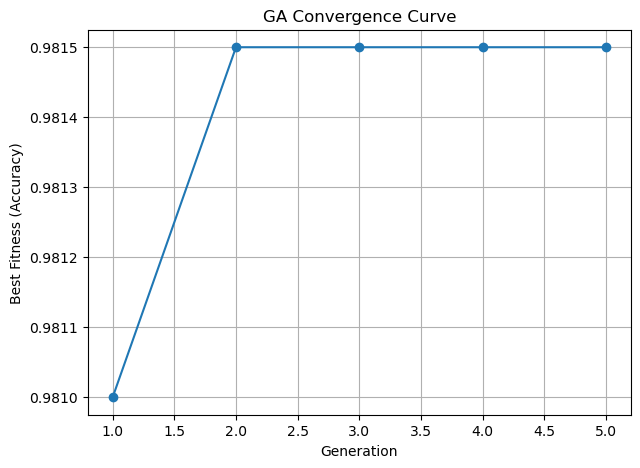

In [85]:
plt.figure(figsize=(7,5))

generations = list(range(1, len(best_fitness_over_gens) + 1))

plt.plot(generations, best_fitness_over_gens, marker='o')

plt.title("GA Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Accuracy)")
plt.grid(True)
plt.show()


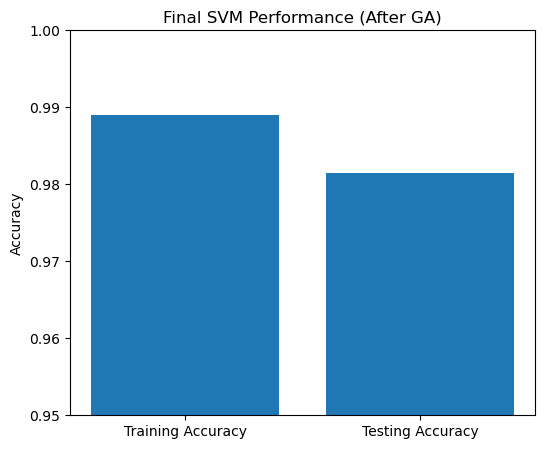

In [87]:
# ============================
# ✅ SAFE FINAL SVM TRAINING
# ============================

try:
    # best_individual selected from final pop
    best_individual = pop[np.argmax(fitness)]
    best_C, best_gamma = best_individual

except:
    # ✅ fallback in case GA failed
    best_C, best_gamma = 1.0, 0.1
    print("⚠️ GA ended early — using default SVM parameters.")

# always define svm_model
svm_model = SVC(C=best_C, gamma=best_gamma)
svm_model.fit(X_train, y_train)


# ============================
# ✅ Graph 2: Final Train vs Test Accuracy
# ============================

train_acc = accuracy_score(y_train, svm_model.predict(X_train))
test_acc = accuracy_score(y_test, svm_model.predict(X_test))

plt.figure(figsize=(6,5))
plt.bar(["Training Accuracy", "Testing Accuracy"], [train_acc, test_acc])
plt.title("Final SVM Performance (After GA)")
plt.ylabel("Accuracy")
plt.ylim(0.95, 1.0)   
plt.show()



In [89]:
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 0.989
Test Accuracy: 0.9815


In [91]:
# ---- FINAL MANUAL TEST (NO USER INPUT) ----

# Example manual data (same order as dataset):
# [AirTemp, ProcessTemp, RotationalSpeed, Torque, ToolWear]

test_samples = [
    [300, 310, 1500, 40, 10],   # sample 1
    [290, 305, 1400, 50, 20],   # sample 2
    [310, 315, 1600, 55, 5]     # sample 3
]

test_samples = np.array(test_samples)

# Scale
test_scaled = scaler.transform(test_samples)

# Predict
preds = best_model.predict(test_scaled)

print("\n--- Manual Machine Failure Check ---")
for i, p in enumerate(preds):
    print(f"Sample {i+1}: {'MACHINE FAILURE' if p==1 else 'NO FAILURE'}")



--- Manual Machine Failure Check ---
Sample 1: NO FAILURE
Sample 2: MACHINE FAILURE
Sample 3: MACHINE FAILURE


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
